In [1]:
from collections import Sequence
from scipy import constants

from scipy.optimize import approx_fprime

import numpy as np
import matplotlib.pyplot as plt

from pescado.mesher import patterns
from pescado.mesher import shapes
from pescado.poisson import Problem, ProblemBuilder
from pescado.tools import SparseVector

import ildos
import solver
import problem

/tmp/ipykernel_32699/862455406.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Sequence


In [2]:
import matplotlib as mpl
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif', size=30)

In [3]:
def disc_ildos(surf):

    dos = 1 * (0.067 * constants.m_e) / (np.pi * constants.hbar ** 2)
    dens_helm = dos * 1e-18 * constants.elementary_charge * surf
    # The value of A corresponds to a one-dimension unit cell

    coord = np.empty((3, 2), dtype=float)
    coord[:, 0] = np.array([-1, 0, 1])
    coord[:, 1] = np.array([0, 0, dens_helm])

    return coord


In [4]:
def ildos_pesca(mu):

#    const = (10
#             * ((2 * 0.067 * constants.m_e * 1e-18) / constants.hbar ** 2) ** (3/2)
#             * (2 / 3)
#             * (1 / (2 * np.pi ** 2)))
    aq = 1e-9
    t = constants.hbar**2 / (2. * constants.m_e * 0.067 * aq**2)
    dens = (1 / t ** 2) * (1 / (2 * np.pi)) * 2 * (constants.elementary_charge ** 2)
   
    if not isinstance(mu, (np.ndarray, Sequence)):
        if mu <= 0:
            dens_ =  0
            ildos_ =  0
        else:
            dens_ = 2 * dens * mu
            ildos_ = dens * (mu ** 2)
    else:
        mu_zero = mu <= 0
        ildos_ = dens * (mu ** 2)
        ildos_[mu_zero] = 0
        dens_ = 2 * np.ones(len(mu)) * dens * mu
        
    return dens_, ildos_

def ildos_zero(mu):
    if not isinstance(mu, (np.ndarray, Sequence)):
        return 0, 0
    else:
        return np.zeros(len(mu)), np.zeros(len(mu))

coord = np.empty((3, 2), dtype=float)
coord[:, 0] = np.array([-1, 0, 1])
coord[:, 1] = np.array([0, 0, ildos_pesca(1)[1]])

ildos_cont = ildos.PContinuousIldos(coordinates=coord, functions=[ildos_zero, ildos_pesca])

In [5]:
dos = 1 * (0.067 * constants.m_e) / (np.pi * constants.hbar ** 2)
dens_helm = dos * 1e-18 * constants.elementary_charge * 2 * 2
print(dens_helm)

1.1195203402076617


In [6]:
# Define the ProblemBuilder
pb = ProblemBuilder()

### Define the Finite volume mesh
# Begin defining the mesh spacing
rect_pattern = patterns.Rectangular.constant(element_size=(4, 10))
# Define the space occupied by the system
system = shapes.Box(lower_left=[-1000, -55], size=[2000, 600])

# Make the mesh
pb.initialize_mesh(
  simulation_region=system, pattern=rect_pattern)

### Set relative dielectric permittivity
dielectric = shapes.Box(lower_left=[-1000, -55], size=[2e3, 160])
pb.set_relative_permittivity(val=12, region=dielectric)

gate = (shapes.Box(lower_left=[-1000, 105], size=[650, 10])
        | shapes.Box(lower_left=[-100, 105], size=[200, 10])
        | shapes.Box(lower_left=[350, 105], size=[650, 10]))
pb.set_relative_permittivity(val=1e4, region=gate)
                             
### Split sites into N, D, H and F.
# Define the remaining regions
dopants = shapes.Box(lower_left=[-1000, 35], size=[2000, 20])
twodeg = shapes.Box(lower_left=[-1000, -4.9], size=[2000, 9.8])

# Define local boundary conditions
pb.set_dirichlet(region=gate, setup_tag='gate')
pb.set_flexible(region=twodeg, setup_tag='2deg')
#pb.set_helmholtz(region=twodeg, setup_tag='2deg')
pb.set_neumann(region=dopants, setup_tag='dopants')

pd = pb.finalized()

In [7]:
sc_solver_A = solver.PieceWiseNewthonRaphson(ildos=ildos_cont, poisson_problem=pd)

In [8]:
poisson_input = {
    'voltage':pd.sparse_vector(val=-0.2, name='gate'), 
    'charge_density':pd.sparse_vector(val=1e23 * 1e-27, name='dopants')}

res = sc_solver_A.solve(
    poisson_input=poisson_input, 
    initial_guess=SparseVector(indices=pd.points(name='2deg'), 
                               values=np.zeros(len(pd.points(name='2deg')))))

Total time in solve 0.6551835536956787
Time spent solving the linear problem 0.4854145050048828
Total time in solve 0.48275208473205566
Time spent solving the linear problem 0.3049447536468506
Total time in solve 0.4528188705444336
Time spent solving the linear problem 0.29500675201416016
Total time in solve 0.4694514274597168
Time spent solving the linear problem 0.3079979419708252
Total time in solve 0.5508139133453369
Time spent solving the linear problem 0.3889284133911133
Total time in solve 0.4754831790924072
Time spent solving the linear problem 0.31222987174987793
Total time in solve 0.6583240032196045
Time spent solving the linear problem 0.49193835258483887
Total time in solve 0.5015766620635986
Time spent solving the linear problem 0.31491613388061523


In [9]:
sc_solver_pl = solver.PieceWiseDichotomy(ildos=ildos_cont, poisson_problem=pd)

res_pi = sc_solver_pl.solve(
    poisson_input=poisson_input, 
    initial_fpoints=np.array([-.5, .0, .5, .9]), 
    initial_guess=SparseVector(indices=pd.points(name='2deg'), 
                               values=np.zeros(len(pd.points(name='2deg')))), 
    max_ite=15)

Total time in solve 0.46190643310546875
Time spent solving the linear problem 0.30140209197998047
Total time in solve 0.4885904788970947
Time spent solving the linear problem 0.33007383346557617
0
Total time in solve 0.4681990146636963
Time spent solving the linear problem 0.30965256690979004
Total time in solve 0.46339988708496094
Time spent solving the linear problem 0.30321836471557617
Total time in solve 0.4535229206085205
Time spent solving the linear problem 0.29436492919921875
Total time in solve 0.46926116943359375
Time spent solving the linear problem 0.3116319179534912
Total time in solve 0.4537835121154785
Time spent solving the linear problem 0.29848599433898926
1
Total time in solve 0.45266270637512207
Time spent solving the linear problem 0.29419589042663574
Total time in solve 0.4625587463378906
Time spent solving the linear problem 0.302722692489624
Total time in solve 0.46233415603637695
Time spent solving the linear problem 0.3023829460144043
Total time in solve 0.460

False

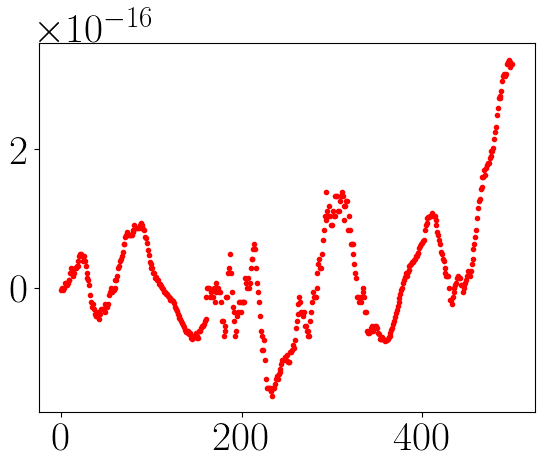

In [10]:
#plt.plot(
#    res['iteration_data'][-1]['quantum_potential'].values, 'go')

a = res_pi['iteration_data'][-2]['iteration_data'][-1]['quantum_potential'].values
b = res_pi['iteration_data'][-1]['iteration_data'][-1]['quantum_potential'].values
plt.plot(a - b, 'r.')
np.any(np.abs(a-b) > 1e-10)
#plt.plot(
#    res_pi['iteration_data'][-4]['iteration_data'][-1]['quantum_potential'].values, 'r.')


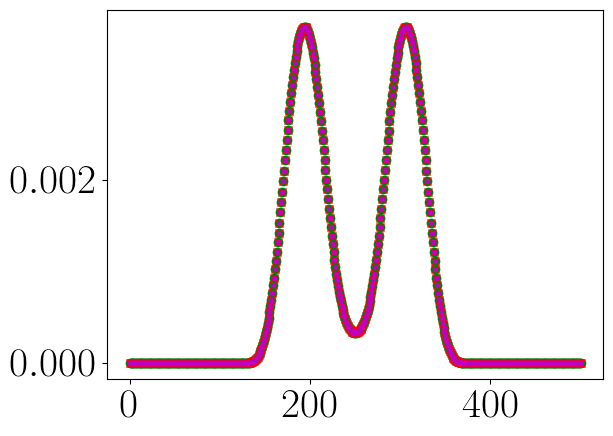

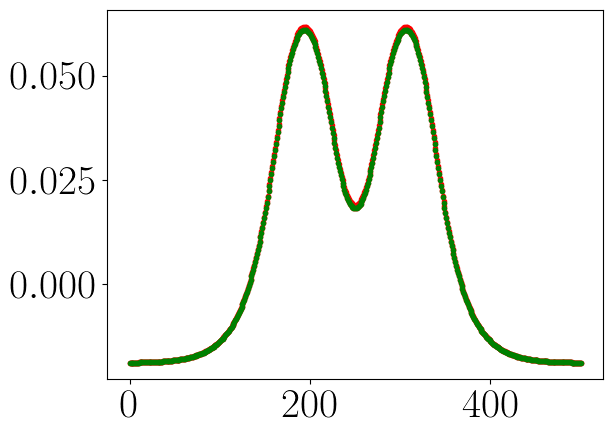

In [12]:
plt.plot(
    res['iteration_data'][-1]['quantum_total_charge'].values, 'go')

plt.plot(
    ildos_pesca(
        res['iteration_data'][-1]['quantum_potential'].values)[1], 'rx')

plt.plot(
    res_pi['iteration_data'][-1]['iteration_data'][-1]['quantum_total_charge'].values, 'm.')

plt.show()
plt.plot(
    res['iteration_data'][-1]['quantum_potential'].values, 'r.')

plt.plot(
    res['iteration_data'][-5]['quantum_potential'].values, 'r.')

plt.plot(
    res['iteration_data'][-1]['chem'].values, 'g.')

#plt.plot(
#    res['iteration_data'][-1]['quantum_potential'].values, 'r.')

#plt.ylim([-.002, 0])
#plt.plot(
#    res['iteration_data'][-2]['quantum_potential'].values, 'g.')


#plt.plot(
#    res_pi['iteration_data'][-1]['iteration_data'][-1]['quantum_potential'].values, 'r.')

In [13]:
old_sc_solver = problem.SchrodingerPoisson(
    ildos=disc_ildos(surf=2), poisson_problem_inst=pd)

In [14]:
initial_config = pd.sparse_vector(val=1, name='2deg', dtype=int)

old_sc_solver.initialize(
    initial_guess=initial_config,
    poisson_problem_input=poisson_input,
    return_poisson_output=False)

old_sc_solver.iterate()

while np.any(
        np.abs(old_sc_solver.iteration_data[-1]['interval']
                - old_sc_solver.iteration_data[-2]['interval']) != 0):

    old_sc_solver.iterate()

gas_charge = old_sc_solver.charge(iteration=-1)
gas_voltage = old_sc_solver.potential(iteration=-1)

Total time in solve 0.4639892578125
Time spent solving the linear problem 0.29549598693847656
Total time in solve 0.5057342052459717
Time spent solving the linear problem 0.3212146759033203
Total time in solve 0.5018515586853027
Time spent solving the linear problem 0.33984923362731934
Total time in solve 0.46590518951416016
Time spent solving the linear problem 0.303286075592041
Total time in solve 0.46941542625427246
Time spent solving the linear problem 0.29648423194885254


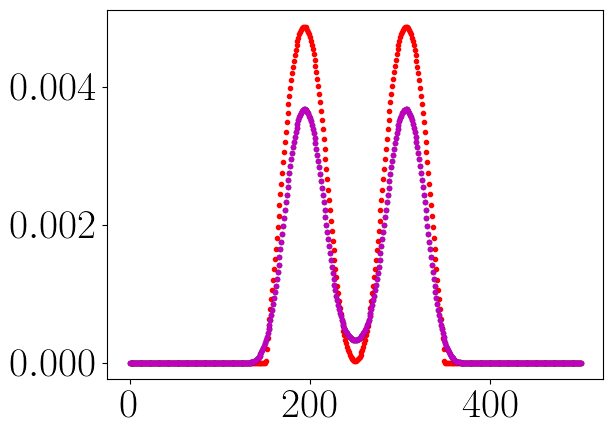

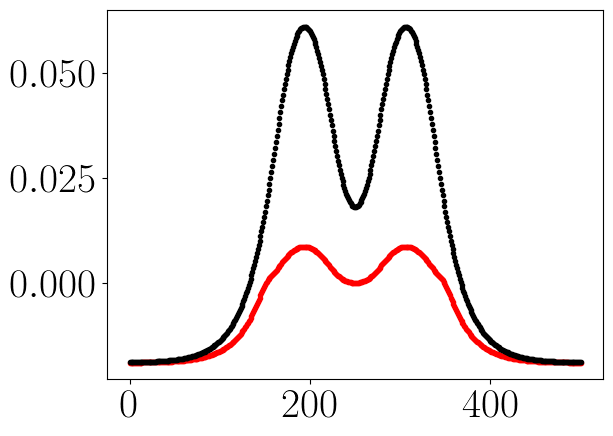

In [15]:
cov_pot = res['iteration_data'][-1]['quantum_potential'].values

plt.plot(gas_charge.values, 'r.')

plt.plot(
    res['iteration_data'][-1]['quantum_total_charge'].values, 'k.')

plt.plot(ildos_cont(cov_pot)[1], 'm.')

#plt.plot(
#    ildos_cont(res_pi['iteration_data'][-1]['iteration_data'][-1]['quantum_potential'].values)[1], 
#    'm')

plt.show()

plt.plot(gas_voltage.values, 'r.')

plt.plot(res['iteration_data'][-1]['quantum_potential'].values, 'k.')

#plt.plot(res_pi['iteration_data'][-1]['iteration_data'][-1]['quantum_potential'].values, 'm.')

#plt.plot(cov_pot, 'g.')



In [16]:
res_pi['iteration_fpoints'][-1]

[array([[-0.5       ,  0.        ],
        [ 0.5       ,  0.24608994],
        [ 0.9       ,  0.79733142]]),
 array([[-0.5       ,  0.        ],
        [ 0.5       ,  0.24608994],
        [ 0.9       ,  0.79733142]]),
 array([[-0.5       ,  0.        ],
        [ 0.5       ,  0.24608994],
        [ 0.9       ,  0.79733142]]),
 array([[-0.5       ,  0.        ],
        [ 0.5       ,  0.24608994],
        [ 0.9       ,  0.79733142]]),
 array([[-0.5       ,  0.        ],
        [ 0.5       ,  0.24608994],
        [ 0.9       ,  0.79733142]]),
 array([[-0.5       ,  0.        ],
        [ 0.5       ,  0.24608994],
        [ 0.9       ,  0.79733142]]),
 array([[-0.5       ,  0.        ],
        [ 0.5       ,  0.24608994],
        [ 0.9       ,  0.79733142]]),
 array([[-0.5       ,  0.        ],
        [ 0.5       ,  0.24608994],
        [ 0.9       ,  0.79733142]]),
 array([[-0.5       ,  0.        ],
        [ 0.5       ,  0.24608994],
        [ 0.9       ,  0.79733142]]),
 array([[-

In [17]:
ildos_cont(u=cov_pot)

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [18]:
res['iteration_data'][-2]['quantum_potential'].values[
    res['iteration_data'][-2]['quantum_potential'].values > 0]

array([0.00030614, 0.00106415, 0.00184796, 0.00265794, 0.00349455,
       0.0043583 , 0.00524974, 0.00616946, 0.00711804, 0.00809606,
       0.00910406, 0.01014254, 0.01121193, 0.01231257, 0.01344467,
       0.0146083 , 0.01580336, 0.01702952, 0.01828621, 0.01957262,
       0.02088761, 0.0222297 , 0.02359708, 0.02498756, 0.02639856,
       0.02782714, 0.02926996, 0.03072338, 0.0321834 , 0.03364579,
       0.03510609, 0.03655971, 0.03800195, 0.03942816, 0.0408337 ,
       0.04221411, 0.04356509, 0.0448826 , 0.04616289, 0.04740251,
       0.04859836, 0.04974767, 0.05084802, 0.05189733, 0.05289383,
       0.05383605, 0.05472281, 0.05555315, 0.05632635, 0.05704187,
       0.05769934, 0.05829853, 0.05883932, 0.05932166, 0.05974559,
       0.06011119, 0.06041856, 0.06066784, 0.06085917, 0.06099268,
       0.06106849, 0.06108673, 0.06104749, 0.06095087, 0.06079693,
       0.06058576, 0.06031744, 0.05999206, 0.05960974, 0.05917065,
       0.05867501, 0.05812312, 0.05751539, 0.05685238, 0.05613